In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

from glob import glob
from sklearn.feature_selection import f_classif, chi2, VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import entropy

In [4]:
file_path = "merged_CICIDS2017.csv"
data = pd.read_csv(file_path)

In [5]:
# Display basic dataset information
print("Original Dataset shape:", data.shape)

Original Dataset shape: (2830743, 79)


In [6]:
# Step 1: Handle Missing Values
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)


# Step 3: Remove Duplicates
data = data.drop_duplicates()
print("Dataset shape after removing duplicates:", data.shape)


Missing values per column:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64
Dataset shape after removing duplicates: (2522362, 79)


In [7]:
# Inspect column names to identify the correct target column
print("Column names in the dataset:", data.columns)

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Set the correct target column name
target_column = 'Label'  # Update this if the target column has a different name

# Encode target labels
if target_column in data.columns:
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    data[target_column] = label_encoder.fit_transform(data[target_column])
else:
    raise KeyError(f"The target column '{target_column}' was not found in the dataset.")

Column names in the dataset: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std',

In [8]:
target_column = 'Label'
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])

In [9]:
# Separate features and target
X = data.drop(columns=[target_column])  # Features
y = data[target_column]                # Target

In [10]:
X = X.fillna(X.median())

In [11]:
X = X.dropna()
y = y[X.index]  # Ensure `y` aligns with `X` after dropping rows

In [12]:
assert not X.isnull().any().any(), "There are still missing values in X."

In [13]:
# Check for infinity or very large values
print("Contains Inf values:", np.isinf(X).any().any())
print("Contains NaN values:", np.isnan(X).any().any())

Contains Inf values: True
Contains NaN values: False


In [14]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column mean (or median)
X.fillna(X.mean(), inplace=True)

In [15]:
print("Contains Inf values (after fix):", np.isinf(X).any().any())
print("Contains NaN values (after fix):", np.isnan(X).any().any())

Contains Inf values (after fix): False
Contains NaN values (after fix): False


In [16]:
# Ensembling for entire dataset and taking top 10 features (Using Weighted Voting Approach)

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold
import numpy as np
import pandas as pd

# Assuming X (features) and y (target) are prepared earlier in the notebook

# Define threshold for variance
threshold = 0.01
variance_selector = VarianceThreshold(threshold=threshold)
variance_selector.fit(X)

# Compute scores for Variance Threshold
feature_variances = X.var(axis=0)
variance_scores = pd.Series(feature_variances.values, index=X.columns)

# Perform ANOVA F-test
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = pd.Series(anova_selector.scores_, index=X.columns)

# Perform Chi-Square test (requires non-negative values)
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X.abs(), y)
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns)

# Calculate PCC for each feature
pcc_scores = X.corrwith(pd.Series(y))
pcc_scores = pcc_scores.abs()  # Use absolute PCC values

# Create a DataFrame to store all scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Variance_Score': variance_scores,
    'ANOVA_Score': anova_scores,
    'Chi2_Score': chi2_scores,
    'PCC_Score': pcc_scores
})

# Define weights for each method (adjustable based on domain knowledge or testing)
weights = {
    'Variance_Score': 0.2,
    'ANOVA_Score': 0.3,
    'Chi2_Score': 0.25,
    'PCC_Score': 0.25
}

# Compute weighted scores
feature_scores['Weighted_Score'] = (
    feature_scores['Variance_Score'] * weights['Variance_Score'] +
    feature_scores['ANOVA_Score'] * weights['ANOVA_Score'] +
    feature_scores['Chi2_Score'] * weights['Chi2_Score'] +
    feature_scores['PCC_Score'] * weights['PCC_Score']
)

# Sort features by weighted score
k = 10  # Number of top features to select
ranked_features = feature_scores.sort_values('Weighted_Score', ascending=False).head(k)

# Reset index to avoid duplicate 'Feature' column in output
#ranked_features = ranked_features.reset_index(drop=True)
#ranked_features.index += 1  

# Display top features selected
print(ranked_features[['Feature', 'Weighted_Score']])

                                 Feature  Weighted_Score
Flow Duration              Flow Duration    2.587818e+14
Fwd IAT Total              Fwd IAT Total    2.581374e+14
Bwd IAT Total              Bwd IAT Total    1.842261e+14
Fwd IAT Max                  Fwd IAT Max    1.532507e+14
Idle Max                        Idle Max    1.527028e+14
Flow IAT Max                Flow IAT Max    1.520340e+14
Idle Mean                      Idle Mean    1.453606e+14
Idle Min                        Idle Min    1.433960e+14
Flow Bytes/s                Flow Bytes/s    1.412709e+14
Fwd Header Length.1  Fwd Header Length.1    9.948590e+13


# Training and Testing using Random Forest Classifier

In [19]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth = 10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='weighted')        
f1 = f1_score(y_test, y_pred, average='weighted')                

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1 Score (weighted): {f1}")


Accuracy: 0.9957592680938115
Precision (weighted): 0.9949104243975946
Recall (weighted): 0.9957592680938115
F1 Score (weighted): 0.9949515576370704


 # Training and Testing using AdaBoost Classifier

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Predict
y_pred = ada_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='weighted')        # Use 'weighted' for multiclass
f1 = f1_score(y_test, y_pred, average='weighted')                # Use 'weighted' for multiclass

# Print Metrics
print(f"Accuracy: {accuracy}")
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1 Score (weighted): {f1}")


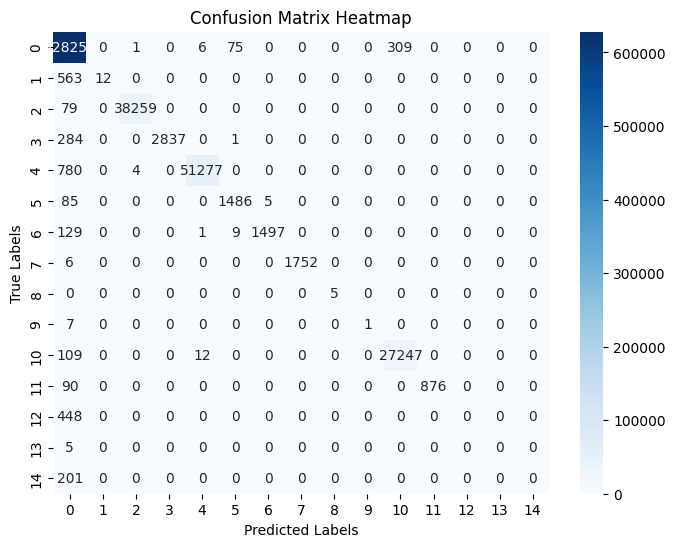

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot the heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.savefig("C:/Users/VVSL VAISHNAVI/Downloads/cm.jpg")
plt.show()


In [ ]:
# ROC Curve

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = rf_model.predict_proba(X_test)  # Get probabilities

# Compute ROC curve and AUC for each class
for i, class_label in enumerate(np.unique(y_test)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Class {class_label} - AUC: {roc_auc}")

Class 0 - AUC: 0.9997526353899739
Class 1 - AUC: 0.9974627938618197
Class 2 - AUC: 0.9999942205063289
Class 3 - AUC: 0.9999316329771085
Class 4 - AUC: 0.9999756269098843
Class 5 - AUC: 0.9999281747362337
Class 6 - AUC: 0.9996770730310741
Class 7 - AUC: 0.9998060953496717
Class 8 - AUC: 1.0
Class 9 - AUC: 0.8285396081146978
Class 10 - AUC: 0.9998880878080951
Class 11 - AUC: 0.9999682972786638
Class 12 - AUC: 0.9981450992944234
Class 13 - AUC: 0.9994702023512496
Class 14 - AUC: 0.9987784834202988


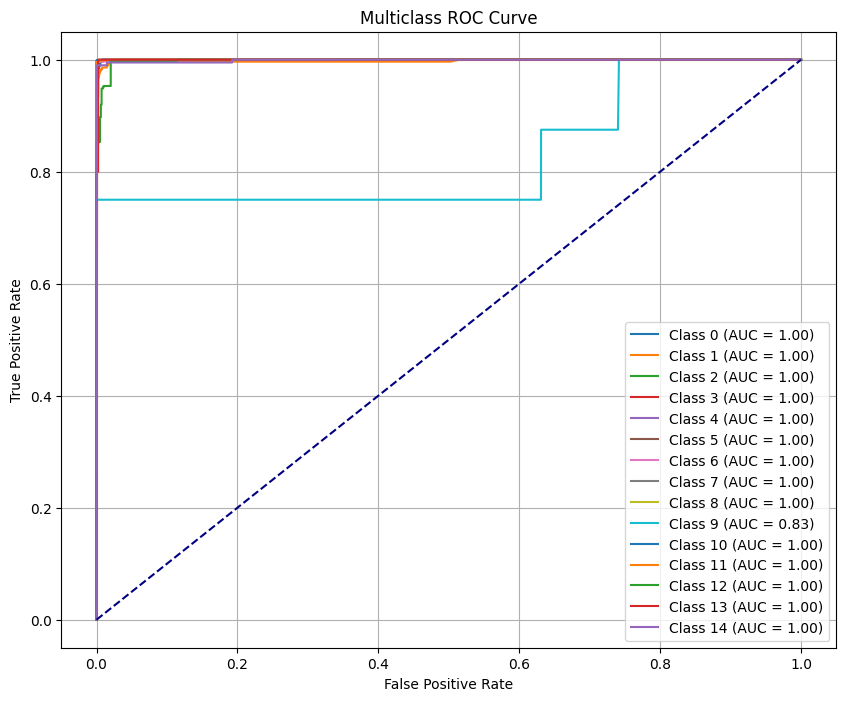

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assume y_test and y_pred_proba are available
# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  # Convert y_test to binary format for each class
n_classes = y_test_binarized.shape[1]

# Get predicted probabilities for each class
y_pred_proba = rf_model.predict_proba(X_test)

# Plotting ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])  # Get false positive and true positive rates
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("C:/Users/VVSL VAISHNAVI/Downloads/roc.jpg")
plt.show()
